In [ ]:
from ast import increment_lineno
from tkinter import Y
import requests
import random
import urllib3
import json
import calplot
import numpy as np
import pandas as pd
import polyline
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from matplotlib import style
import folium
import math
from mpl_toolkits.basemap import Basemap
import os
import pickle
from google.colab import drive
from google.colab import files
load = files.upload()
#choose file
d = next(iter(load.values()))
#get contents from json
data = json.loads(d.decode())
#convert json to dict

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [ ]:
!pip install calplot
!pip install polyline
!pip install basemap

In [4]:
clientid = data["client_id"]
clientsecret = data["client_secret"]
refreshtoken = data["refresh_token"]
#data & tokens from hidden json
auth_link = "https://www.strava.com/oauth/token"
activities_link = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': clientid,
    'client_secret': clientsecret,
    'refresh_token': refreshtoken,
    'grant_type': "refresh_token",
    'f': 'json'
    }

res = requests.post(auth_link, data=payload, verify=False)
access_token = res.json()['access_token']
#use refresh token to get new access token

heading = {'Authorization': 'Bearer ' + access_token}
param = {'per_page': 200, 'page':1}

In [5]:
my_fulldataset = requests.get(activities_link, headers=heading, params=param).json()
activity_df = pd.json_normalize(my_fulldataset)

cols = ['name', 'type', 'distance', 'moving_time', 'elapsed_time', 'average_speed', 'max_speed', 'start_date_local','location_city','location_country','achievement_count','kudos_count','start_latlng','end_latlng','map.summary_polyline']
#specifying data (creating table with only the useful information)

activity_df = activity_df[cols]

def viewdata(data):
    #easy insight into data in any table
    print(data.columns)
    #see 'template'
    print(data.shape)
    #dimensions
    print(data['type'].value_counts())
    #see distribution of activities

activity_df["start_date_local"] = pd.to_datetime(activity_df['start_date_local'])
activity_df = activity_df.set_index('start_date_local')
#converting to datetime and setting as the index
activity_df['distance'] = round(activity_df['distance']/1000,2)
#conversion from m to km
activity_df['average_speed'] = round(activity_df['average_speed'] * 3.6,2)
activity_df['max_speed'] = round(activity_df['max_speed'] * 3.6,2)
#conversion from m/s to km/h

#creating tables of activities
bike_activities_df = activity_df.loc[activity_df['type'] == 'Ride']
walk_activities_df = activity_df.loc[activity_df['type']=='Walk']



/usr/local/lib/python3.10/dist-packages/calplot/calplot.py:193: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/usr/local/lib/python3.10/dist-packages/calplot/calplot.py:193: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(


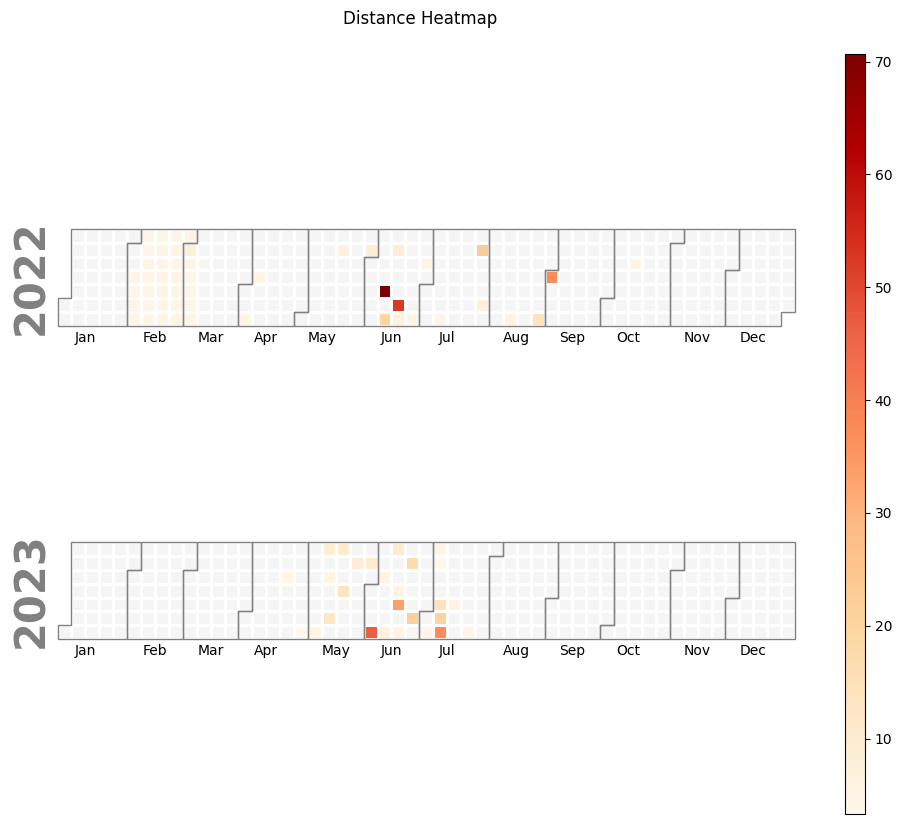

In [6]:
plt.style.use("default")

heatmap = calplot.calplot(data = bike_activities_df['distance'],how='sum',cmap="OrRd",suptitle="Distance Heatmap",dayticks=False,figsize=(10,8))


Text(0, 0.5, 'Average Speed (KM/H)')

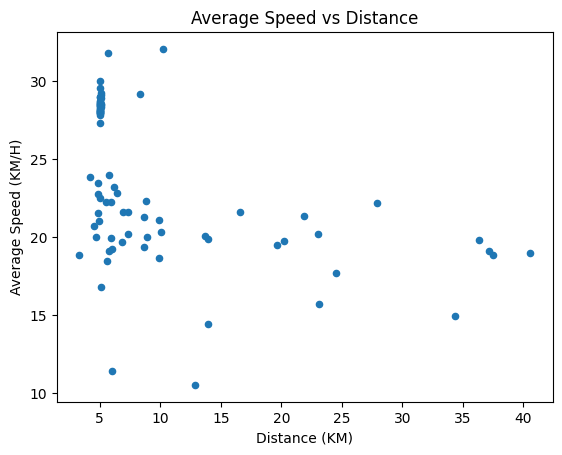

In [7]:
avgspeed_distance = pd.DataFrame(bike_activities_df, columns=['average_speed', 'distance'])
avgspeed_distance.plot(x = 'distance', y = 'average_speed', kind = 'scatter')
plt.title("Average Speed vs Distance")
plt.xlabel("Distance (KM)")
plt.ylabel("Average Speed (KM/H)")

Text(0, 0.5, 'Kudos Count')

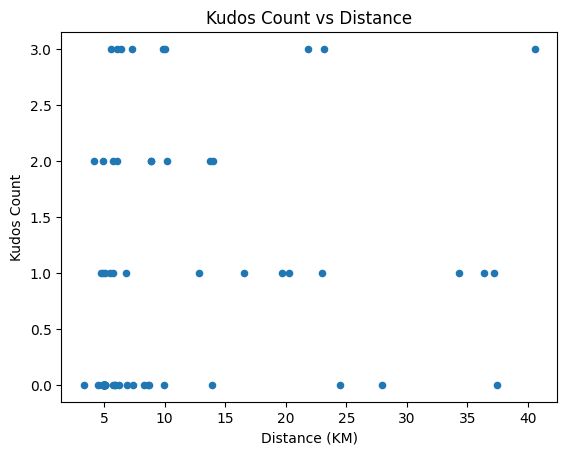

In [10]:
achievement_distance = pd.DataFrame(bike_activities_df, columns=['kudos_count','distance'])
achievement_distance.plot(x='distance',y='kudos_count',kind='scatter')
plt.title("Kudos Count vs Distance")
plt.xlabel("Distance (KM)")
plt.ylabel("Kudos Count")

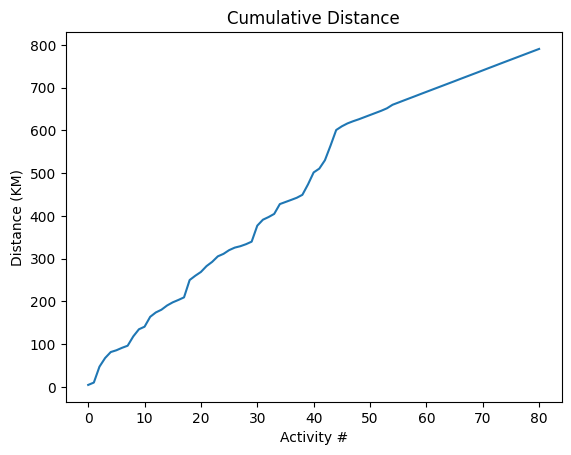

In [11]:
def cumulative(bike_activities):
    plt.figure("Cumulative Distance")
    listx = []
    for i in range(0,len(bike_activities)):
        listx.append(i)
    cumulative_distance = bike_activities_df['distance'].cumsum(axis=0)
    plt.plot(listx,cumulative_distance)
    plt.title("Cumulative Distance")
    plt.xlabel("Activity #")
    plt.ylabel("Distance (KM)")

cumulative(bike_activities_df)
#cumulative distance

In [12]:
all = bike_activities_df['map.summary_polyline'].to_numpy()

adjusted_df = bike_activities_df.loc[bike_activities_df['distance'] >=15]
adjusted_array = adjusted_df['map.summary_polyline'].to_numpy()
#create an array of all rides over 15km to add on interactive map

def geomap(bike_list):
  colour_cycle=0
  colours=['red','red','blue','purple','orange','white','pink','green','gray']
  #colour info for line
  route_map = folium.Map(location=[43.49854808219178, -79.70272301369863], zoom_start = 11, tiles='CartoDB dark_matter')
  #making the map -- setting centroid as Oakville
  for i in range(0,len(bike_list)):
    #iterate through all bike activities
    if bike_list[i] is not None:
      #check if bike activity has polylines (stationary activities dont have polylines)
      decode = polyline.decode(bike_list[i])
      #decode into lat,lng
      colour_cycle+=1
      if colour_cycle >= len(colours):
        colour_cycle=0
    for element in decode:
      #add the polyline to the map
      folium.PolyLine(locations=decode, smooth_factor = 2, color = colours[colour_cycle]).add_to(route_map)
  display(route_map)

geomap(adjusted_array)


plt.show()

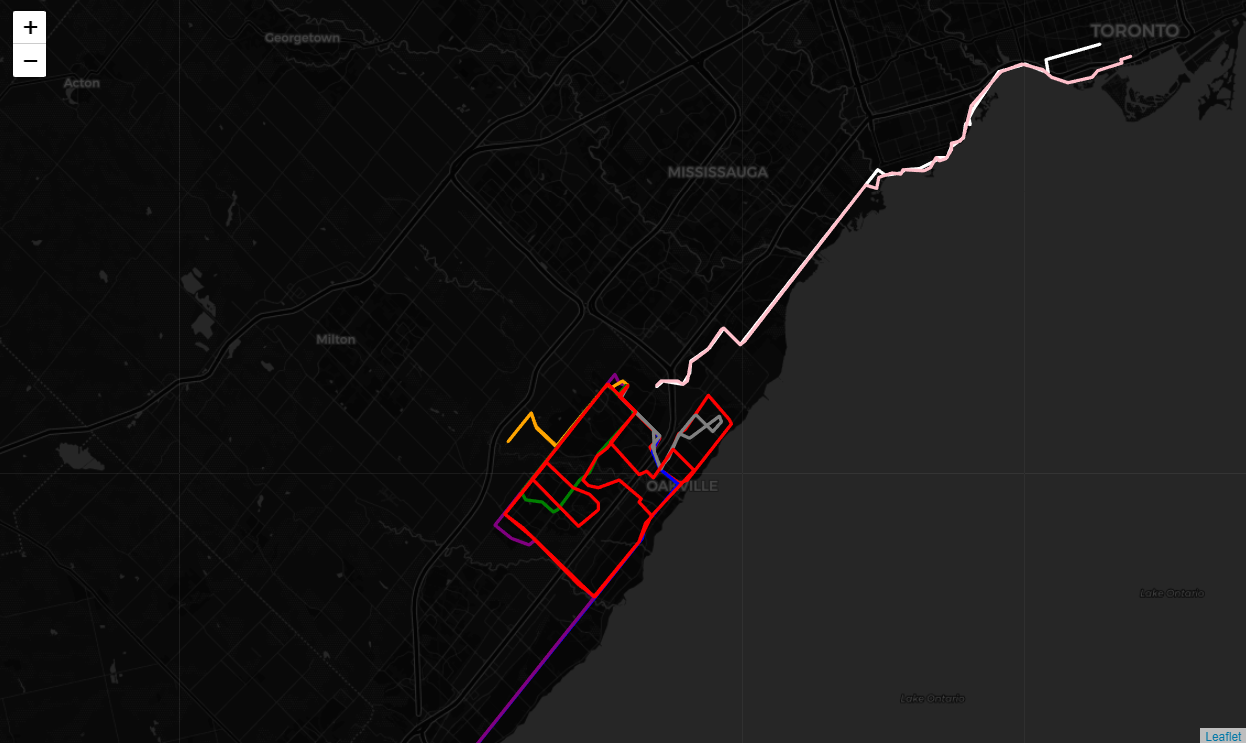

In [14]:
total_distance = bike_activities_df["distance"].sum()
total_moving_time = bike_activities_df["moving_time"].sum()
converted_total_moving_time = total_moving_time/3600
total_elapsed_time = bike_activities_df["elapsed_time"].sum()
total_achievements = bike_activities_df["achievement_count"].sum()
total_kudos = bike_activities_df["kudos_count"].sum()
farthest_ride = bike_activities_df['distance'].max()
highest_speed = bike_activities_df['max_speed'].max()

num_bikes = len(bike_activities_df)
#just curious


print(f'Total Number of Rides: {num_bikes}')
print(f'Total Distance: {total_distance:.2f} km')
print(f'Total Moving Time: {converted_total_moving_time:.2f} hours')
print(f'Total Achievements: {total_achievements}')
print(f'Total Kudos: {total_kudos}')
print(f'Longest Distance: {farthest_ride} km')
print(f'Fastest Speed Recorded {highest_speed} km/h')

Total Number of Rides: 81
Total Distance: 790.68 km
Total Moving Time: 38.73 hours
Total Achievements: 247
Total Kudos: 59
Longest Distance: 40.57 km
Fastest Speed Recorded 84.97 km/h
